<a href="https://colab.research.google.com/github/BrunoPinos/Categoriser-automatiquement-des-questions/blob/dev/P5_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# data analysis and wrangling
import pandas as pd
from scipy import stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

# text
from gensim.models import LdaMulticore
from gensim.models import Phrases, CoherenceModel
from gensim.matutils import corpus2csc
from IPython.display import display, HTML

# Save objects
import joblib

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier

# Set working directory
import time
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/P5')

# Data table display for Pandas dataframes
from google.colab import data_table
%load_ext google.colab.data_table

Import

In [ ]:
df = joblib.load('df.sav')
texts_cleaned = joblib.load('texts_cleaned.sav')
dictionary = joblib.load('dictionary.sav')

Create the main dataframe with Tags and Text (cleaned) features

In [ ]:
df['Text'] = texts_cleaned

df.drop(['Body', 'Title'], axis=1, inplace=True)

Split Tag

In [ ]:
list_tags = df.Tags.apply(lambda tags: tags[1:-1].split('><'))
list_tags

Id
10000005                           [php, arrays, sorting]
10000083    [javascript, events, event-handling, handler]
10000335                          [linux, gdb, libc, ldd]
10003270                         [c, arrays, gcc, struct]
10003562            [objective-c, ios, storyboard, segue]
                                ...                      
1213074           [wpf, winforms, interop, drag-and-drop]
1213127         [java, mysql, database-connection, sleep]
1213137                             [iphone, uitableview]
1213144                      [sql-server-ce, data-paging]
1213217              [perl, dependencies, module, legacy]
Name: Tags, Length: 101366, dtype: object

In [ ]:
list_tags_total = list()

for row in list_tags:
  for word in row:
    list_tags_total.append(word)

list_tags_total = pd.Series(list_tags_total)
print(f'There are {list_tags_total.nunique()} Tags')

There are 14413 Tags


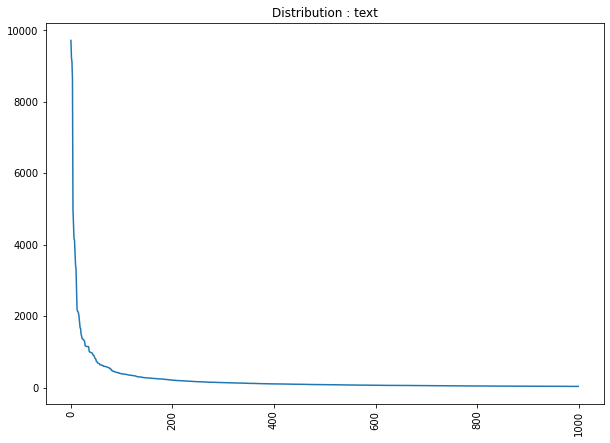

In [ ]:
data_count = list_tags_total.value_counts()
fig = plt.figure(1, figsize=(10, 7))
sn.lineplot(x = range(0, 1000), y = data_count[0:1000])
plt.xticks(rotation=90)
plt.title('Distribution : text')
plt.show()

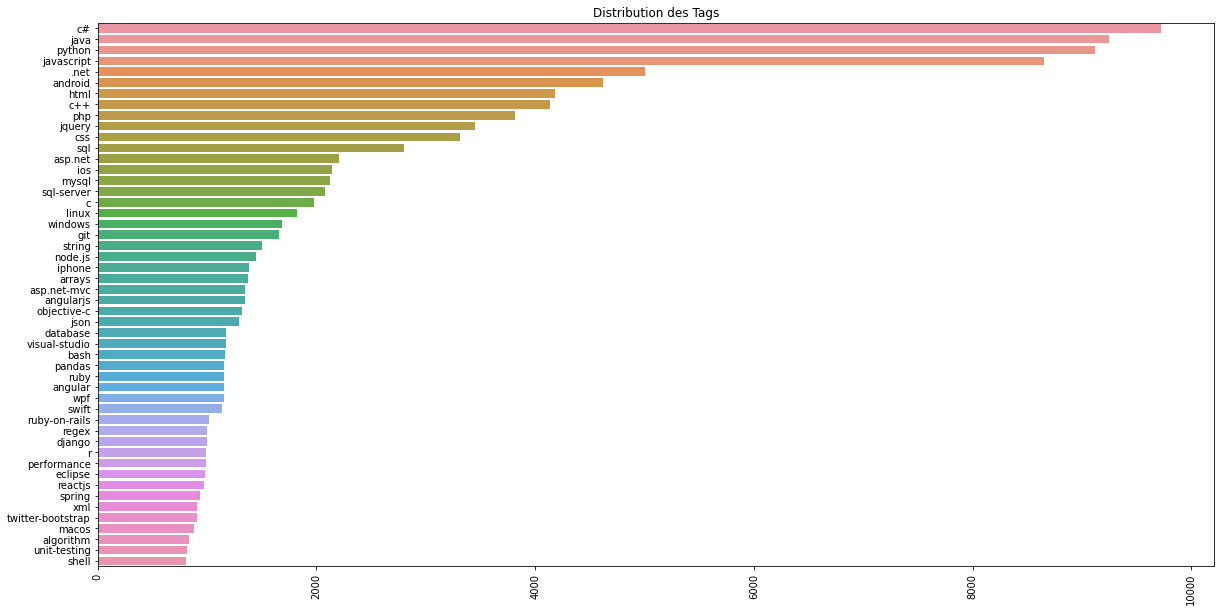

In [ ]:
fig = plt.figure(1, figsize=(20, 10))
sn.barplot(x = data_count[0:50].values, y = data_count[0:50].index)
plt.xticks(rotation=90)
plt.title('Distribution des Tags')
plt.show()

In [ ]:
list_tags

Id
10000005                           [php, arrays, sorting]
10000083    [javascript, events, event-handling, handler]
10000335                          [linux, gdb, libc, ldd]
10003270                         [c, arrays, gcc, struct]
10003562            [objective-c, ios, storyboard, segue]
                                ...                      
1213074           [wpf, winforms, interop, drag-and-drop]
1213127         [java, mysql, database-connection, sleep]
1213137                             [iphone, uitableview]
1213144                      [sql-server-ce, data-paging]
1213217              [perl, dependencies, module, legacy]
Name: Tags, Length: 101366, dtype: object

In [ ]:
n = 10
i = 0
good_tags = data_count[0:n].index
list_tag_n = list()

for row in list_tags:
  list_tag_n.append(list())
  for word in row:
    if word in good_tags:
      list_tag_n[i].append(word)
  i += 1

In [ ]:
df['Tags'] = list_tag_n
df = df.loc[df['Tags'].apply(len) > 0]

In [ ]:
df

,Tags,Text
Id,,
10000005,[php],"[php, sort, array, field, possible, duplicate,..."
10000083,[javascript],"[javascript, event, handler, parameter, want, ..."
10003683,[javascript],"[extract, number, string, javascript, string, ..."
10006459,[javascript],"[regular, expression, address, validation, wan..."
10006529,[javascript],"[change, color, highchart, use, highchart, mak..."
...,...,...
1212838,[c#],"[send, mails, image, inline, use, smtpclient, ..."
1212882,[java],"[convert, byte, array, image, java, without, k..."
1212914,[c#],"[enable, scroll, microsoft, chart, control, wi..."


In [ ]:
# I binarize tags
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(df['Tags'])

# I transform the text with dictionary
X = df['Text'].apply(dictionary.doc2bow)
X = corpus2csc(X, num_terms=len(dictionary)).transpose()

In [ ]:
X_train, X_test, y_train, y_test = \
                        train_test_split(X,
                                         y,
                                         test_size=0.20,
                                         shuffle=True,
                                         random_state=0)

Naive bayesien

In [ ]:
estimator_nb = Pipeline([('tfidf', TfidfTransformer()), 
                         ('nb', MultiOutputClassifier(MultinomialNB())),
                        ])

parameters = {'nb__estimator__alpha': [1.0, 3e-1, 1e-1, 3e-2, 1e-2]}

nb_grid = GridSearchCV(estimator_nb,
                        param_grid=parameters,
                        scoring='jaccard_samples',
                        n_jobs=-1,
                        verbose=1,
                        cv=5)

nb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfTransformer(norm='l2',
                                                         smooth_idf=True,
                                                         sublinear_tf=False,
                                                         use_idf=True)),
                                       ('nb',
                                        MultiOutputClassifier(estimator=MultinomialNB(alpha=1.0,
                                                                                      class_prior=None,
                                                                                      fit_prior=True),
                                                              n_jobs=None))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'nb__estimator__alpha': [1.0, 0.3, 

In [ ]:
nb_grid.best_params_

{'nb__estimator__alpha': 0.03}

In [ ]:
nb_grid.best_score_

0.4442073088366384

In [ ]:
print("Score sur test set: ",
      round(nb_grid.score(X_test, y_test), 3))

Score sur test set:  0.461


SVM

In [ ]:
estimator_svm = Pipeline([('tfidf', TfidfTransformer()), 
                          ('svm',
                           MultiOutputClassifier(LinearSVC(max_iter=1000)))
                          ])

parameters = {'svm__estimator__C': [1, 10, 30]}

svm_grid = GridSearchCV(estimator_svm,
                        param_grid=parameters,
                        scoring='jaccard_samples',
                        n_jobs=-1,
                        verbose=1,
                        cv=5)

svm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfTransformer(norm='l2',
                                                         smooth_idf=True,
                                                         sublinear_tf=False,
                                                         use_idf=True)),
                                       ('svm',
                                        MultiOutputClassifier(estimator=LinearSVC(C=1.0,
                                                                                  class_weight=None,
                                                                                  dual=True,
                                                                                  fit_intercept=True,
                                                                                  intercept_scaling=1,
                                           

In [ ]:
svm_grid.best_params_

{'svm__estimator__C': 1}

In [ ]:
svm_grid.best_score_

0.6885335673892814

In [ ]:
print("Score sur test set: ",
      round(svm_grid.score(X_test, y_test), 3))

Score sur test set:  0.701


MLPclassifier

In [ ]:
estimator_mlp = Pipeline([('tfidf', TfidfTransformer()), 
                          ('mlp', MultiOutputClassifier(MLPClassifier()))])

parameters = {
    'mlp__estimator__max_iter' : [50], #maximum iteration
}

mlp_grid = GridSearchCV(estimator_mlp,
                        param_grid=parameters,
                        scoring='jaccard_samples',
                        n_jobs=-1,
                        verbose=1,
                        cv=5)

mlp_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 62.9min finished
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWa

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfTransformer(norm='l2',
                                                         smooth_idf=True,
                                                         sublinear_tf=False,
                                                         use_idf=True)),
                                       ('mlp',
                                        MultiOutputClassifier(estimator=MLPClassifier(activation='relu',
                                                                                      alpha=0.0001,
                                                                                      batch_size='auto',
                                                                                      beta_1=0.9,
                                                                                      beta_2=0.999,
                       

In [ ]:
mlp_grid.best_params_

{'mlp__estimator__max_iter': 50}

In [ ]:
mlp_grid.best_score_

0.6840555608793153

In [ ]:
print("Score sur test set: ",
      round(mlp_grid.score(X_test, y_test), 3))

Score meilleur Naive Bayes sur test set:  0.703


Xgboost

In [ ]:
estimator_nb = Pipeline([('tfidf', TfidfTransformer()), 
                         ('xgb', MultiOutputClassifier(
                             GradientBoostingClassifier())),
                        ])

parameters = {
    'xgb__estimator__n_estimators' : [100], #nombre d'arbres de décision
    'xgb__estimator__min_samples_leaf' : [2], #nombre de feuilles minimales 
    'xgb__estimator__max_features': ['sqrt'] #nombre de features observées
}

xgb_grid = GridSearchCV(estimator_nb,
                        param_grid=parameters,
                        scoring='jaccard_samples',
                        n_jobs=-1,
                        verbose=1,
                        cv=5)

xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfTransformer(norm='l2',
                                                         smooth_idf=True,
                                                         sublinear_tf=False,
                                                         use_idf=True)),
                                       ('xgb',
                                        MultiOutputClassifier(estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                                                   criterion='friedman_mse',
                                                                                                   init=None,
                                                                                                   learning_rate=0.1,
                                                                

In [ ]:
xgb_grid.best_params_

{'xgb__estimator__max_features': 'sqrt',
 'xgb__estimator__min_samples_leaf': 2,
 'xgb__estimator__n_estimators': 100}

In [ ]:
xgb_grid.best_score_

0.3128335114537086

In [ ]:
print("Score sur test set: ",
      round(xgb_grid.score(X_test, y_test), 3))

Score meilleur Naive Bayes sur test set:  0.452


RandomForest

In [ ]:
estimator_nb = Pipeline([('tfidf', TfidfTransformer()), 
                         ('rf', RandomForestClassifier()),
                        ])

parameters = {
    'rf__n_estimators' : [100], #nombre d'arbres de décision
    'rf__min_samples_leaf' : [5], #nombre de feuilles minimales 
    'rf__max_features': ['auto', 'sqrt'] #nombre de features observées
}

rf_grid = GridSearchCV(estimator_nb,
                        param_grid=parameters,
                        scoring='jaccard_samples',
                        n_jobs=-1,
                        verbose=1,
                        cv=5)

rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfTransformer(norm='l2',
                                                         smooth_idf=True,
                                                         sublinear_tf=False,
                                                         use_idf=True)),
                                       ('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                 

In [ ]:
rf_grid.best_params_

{'rf__max_features': 'auto',
 'rf__min_samples_leaf': 5,
 'rf__n_estimators': 100}

In [ ]:
rf_grid.best_score_

0.5828971653504798

In [ ]:
print("Score sur test set: ",
      round(rf_grid.score(X_test, y_test), 3))

Score sur test set:  0.603
